# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

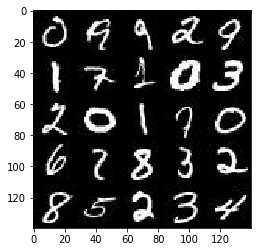

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

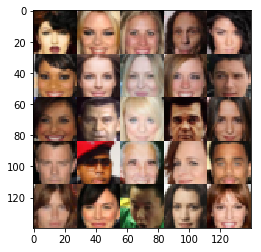

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='valid')
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        # 12x12x64
    
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        # 6x6x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 6x6x256
        
        flat = tf.reshape(x3, (-1, 6*6*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    filters = [512, 256, 128, 32]
        
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*filters[0])
        x1 = tf.reshape(x1, (-1, 7, 7, filters[0]))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
                
        # print(x1.get_shape())
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters[1], 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # print(x2.get_shape())
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters[2], 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 28x28x128
        
        x4 = tf.layers.conv2d_transpose(x3, filters[3], 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #print(x4.get_shape())
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        #print(logits.get_shape())
        # 28x28xout_chanel_dim
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    width = data_shape[1]
    height = data_shape[2]
    out_channel_dim = data_shape[3]
    
    
    real_input, z_input, lr = model_inputs(width, height, out_channel_dim, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every = 100
    print_every = 10
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1                
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, out_channel_dim, data_image_mode)
                    
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({z_input: batch_z, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),                          
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.9714... Generator Loss: 5.3184
Epoch 1/2... Discriminator Loss: 0.4052... Generator Loss: 4.4408
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 2.0852
Epoch 1/2... Discriminator Loss: 2.2911... Generator Loss: 0.2674
Epoch 1/2... Discriminator Loss: 2.0244... Generator Loss: 1.4169
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 1.9279
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.6635
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 1.4117
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 1.3255


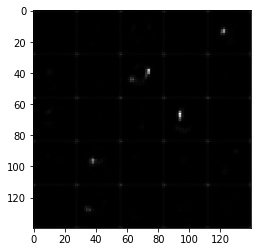

Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.5279
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 1.7518... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 1.1616
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.5660
Epoch 1/2... Discriminator Loss: 1.8052... Generator Loss: 0.3909
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.6014
Epoch 1/2... Discriminator Loss: 1.5398... Generator Loss: 0.4618
Epoch 1/2... Discriminator Loss: 1.4818... Generator Loss: 0.5105
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.9852


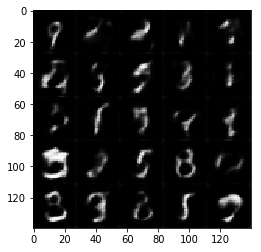

Epoch 1/2... Discriminator Loss: 1.2791... Generator Loss: 0.8468
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 2.0919
Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.9162
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 1.2978
Epoch 1/2... Discriminator Loss: 1.4118... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.5215... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.7335
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.9396


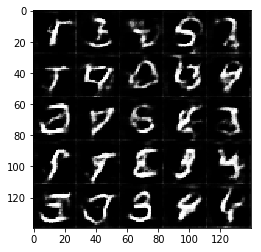

Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 0.9941
Epoch 1/2... Discriminator Loss: 1.4879... Generator Loss: 1.7992
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 1.3653
Epoch 1/2... Discriminator Loss: 1.6050... Generator Loss: 0.4370
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 1.5570
Epoch 1/2... Discriminator Loss: 1.5561... Generator Loss: 2.0072
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.9502


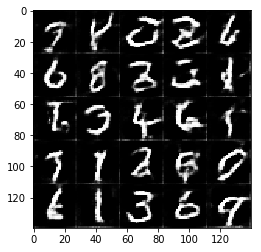

Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 0.7105
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 1.1469
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 1.0987
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.5169
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.4387... Generator Loss: 1.8612
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 1.1435
Epoch 1/2... Discriminator Loss: 1.5430... Generator Loss: 0.4243


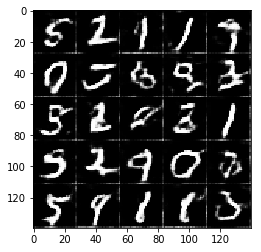

Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 1.5454
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.9067
Epoch 1/2... Discriminator Loss: 1.7378... Generator Loss: 0.3731
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 1.1420
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 1.7880
Epoch 1/2... Discriminator Loss: 1.5607... Generator Loss: 0.4643
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.5641
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 1.8002
Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 0.8187


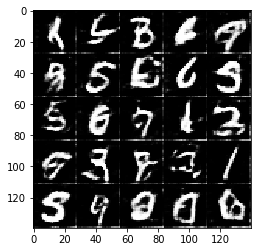

Epoch 1/2... Discriminator Loss: 1.7180... Generator Loss: 0.3359
Epoch 1/2... Discriminator Loss: 2.0901... Generator Loss: 2.8676
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 0.9299
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 0.4684
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 1.7339
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 1.3414
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 0.7368


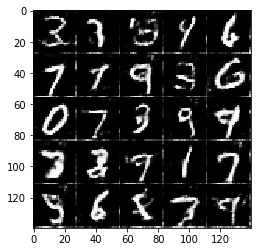

Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.6098
Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.4319
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 1.7932
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.8971
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.6059... Generator Loss: 0.4128
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 1.3905
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 1.1821


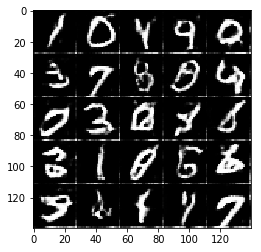

Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 1.3480
Epoch 1/2... Discriminator Loss: 1.5940... Generator Loss: 0.4270
Epoch 1/2... Discriminator Loss: 1.1494... Generator Loss: 1.3858
Epoch 1/2... Discriminator Loss: 1.6665... Generator Loss: 2.6574
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.5007
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 0.9868
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 1.8257
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 1.2692
Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.5000


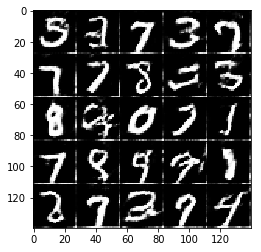

Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 1.1055
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.9143
Epoch 1/2... Discriminator Loss: 1.2704... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 1.1784
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 1.3394
Epoch 2/2... Discriminator Loss: 1.4777... Generator Loss: 0.5383
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 1.2461
Epoch 2/2... Discriminator Loss: 1.1779... Generator Loss: 0.7146


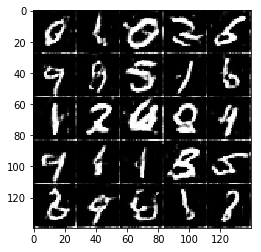

Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.5452
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.7256
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.5884
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 1.3314
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 1.9806
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 1.5351
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 1.0309
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 0.9723
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 0.7163
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 1.2615


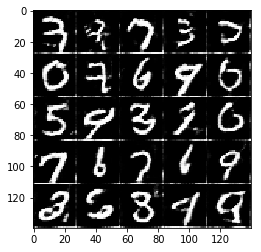

Epoch 2/2... Discriminator Loss: 2.1970... Generator Loss: 2.8448
Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 1.2264
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 1.3631
Epoch 2/2... Discriminator Loss: 1.9865... Generator Loss: 0.3113
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.6359
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.2671
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 1.5899
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 1.5293
Epoch 2/2... Discriminator Loss: 1.0403... Generator Loss: 1.2547
Epoch 2/2... Discriminator Loss: 1.8451... Generator Loss: 0.3208


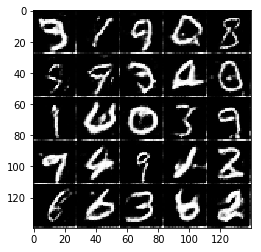

Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.8740
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.8127
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 1.4817
Epoch 2/2... Discriminator Loss: 1.1898... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 1.3085
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 1.0431
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 2.0467


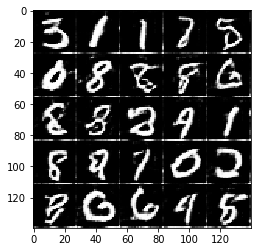

Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.5016... Generator Loss: 0.5288
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 2.2186
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 1.1189... Generator Loss: 1.6401
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 1.6463
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.3714
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 0.8688
Epoch 2/2... Discriminator Loss: 1.9483... Generator Loss: 2.9458


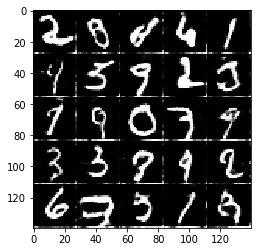

Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 1.8055
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.6286
Epoch 2/2... Discriminator Loss: 1.1324... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 1.3874... Generator Loss: 2.2817
Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 1.0140
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.6909... Generator Loss: 0.4322
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.9747
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.5882
Epoch 2/2... Discriminator Loss: 1.5593... Generator Loss: 2.4711


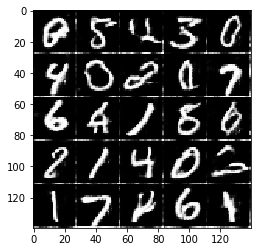

Epoch 2/2... Discriminator Loss: 1.1572... Generator Loss: 0.9120
Epoch 2/2... Discriminator Loss: 1.9709... Generator Loss: 0.4179
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 0.8991
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 1.0169
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 2.1227
Epoch 2/2... Discriminator Loss: 1.6515... Generator Loss: 0.4667
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 1.3250
Epoch 2/2... Discriminator Loss: 0.9401... Generator Loss: 1.2843
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 1.2935
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 1.9485


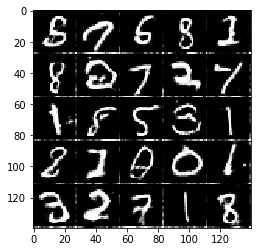

Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.1844... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 1.8096
Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 1.2872
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 1.0253
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 1.5030
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.9272


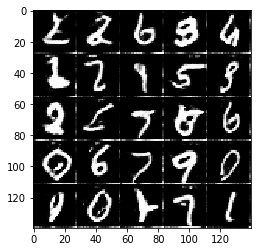

Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 0.9324
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 1.4013
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 1.5156
Epoch 2/2... Discriminator Loss: 1.6574... Generator Loss: 0.4437
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 0.7792... Generator Loss: 1.5727
Epoch 2/2... Discriminator Loss: 1.1013... Generator Loss: 0.8910
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 1.3954
Epoch 2/2... Discriminator Loss: 1.0604... Generator Loss: 0.8737
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.8989


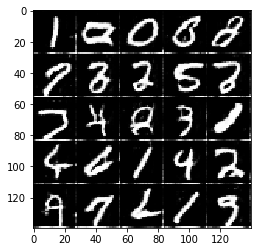

Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.7601
Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 1.7887
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.1170
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 1.1533
Epoch 2/2... Discriminator Loss: 1.2940... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.3811
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 2.2160
Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.6040


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 6.8873
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.9165
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 3.2546
Epoch 1/1... Discriminator Loss: 2.2214... Generator Loss: 3.3138
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.9261
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 2.3282
Epoch 1/1... Discriminator Loss: 6.0035... Generator Loss: 8.2693
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.8240


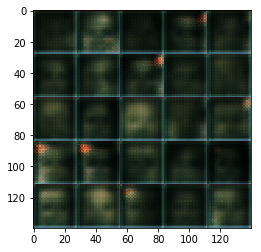

Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 1.1390


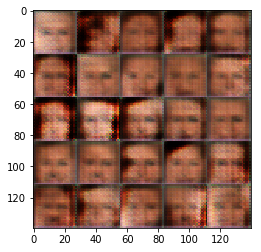

Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 1.4000
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 1.4154
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 1.9599


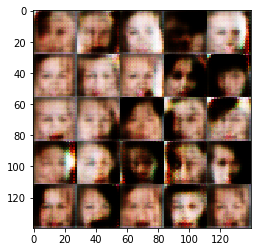

Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 1.2844
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.7250... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6551


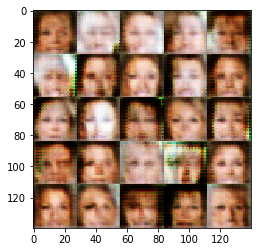

Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.7074... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.8736... Generator Loss: 0.2930
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.8364... Generator Loss: 1.9249


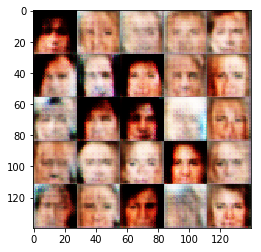

Epoch 1/1... Discriminator Loss: 1.8068... Generator Loss: 0.3426
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.6893... Generator Loss: 1.4196
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7727


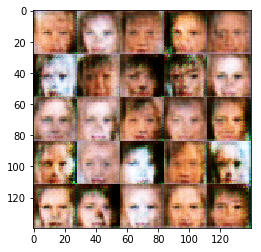

Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7771


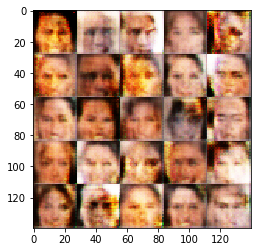

Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 1.3991
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7132


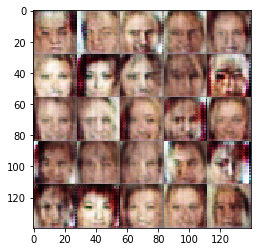

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.6940


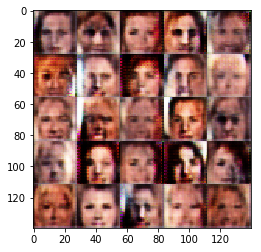

Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.6578... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.8018


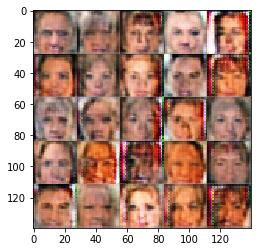

Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7619


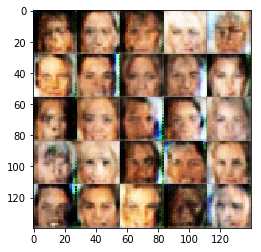

Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8034


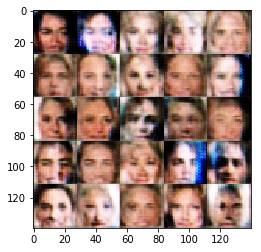

Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 1.1318
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.7520


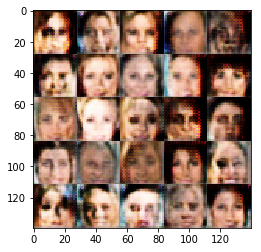

Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7371


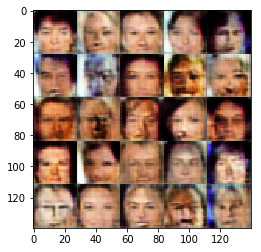

Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.9919


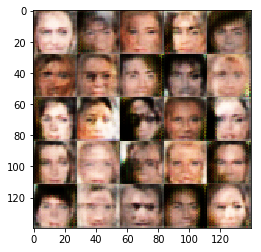

Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 1.6602... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.7790


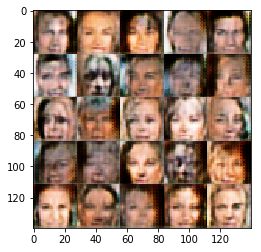

Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.9435


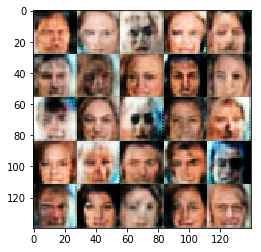

Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6801


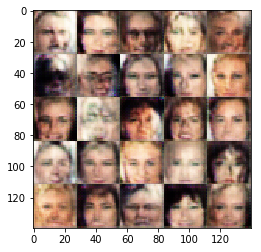

Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.5936


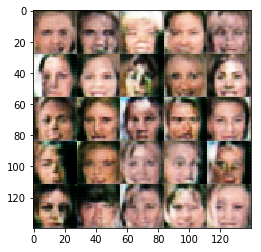

Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 1.2938
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 1.0222


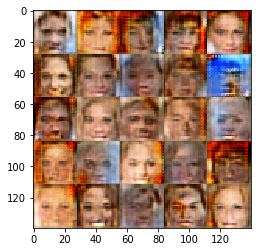

Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8053


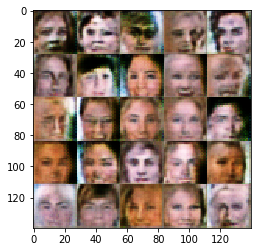

Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7837


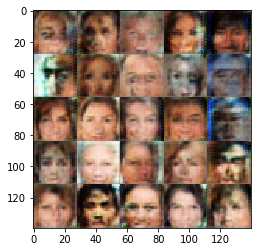

Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 1.0378


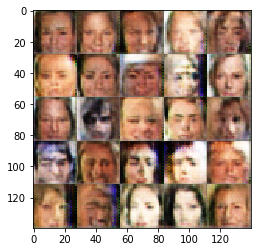

Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8622


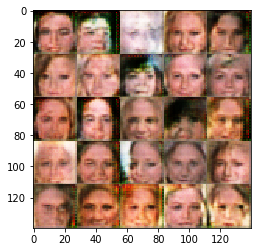

Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.9866


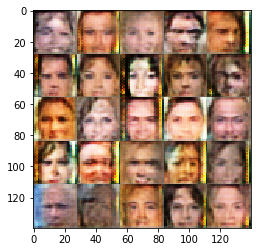

Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 1.5873


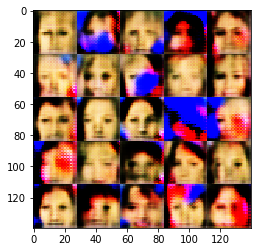

Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 3.2988
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 3.4375
Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 1.9995
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 3.6255
Epoch 1/1... Discriminator Loss: 0.4915... Generator Loss: 2.3688
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 2.2316
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 1.8571... Generator Loss: 0.4755


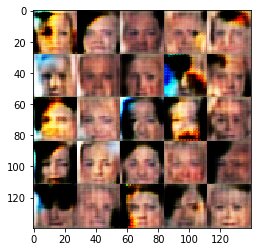

Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 1.8355
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.4637
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 2.0859
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.7853


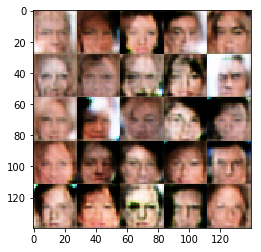

Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.3997
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.3559
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.3472
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.7076... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 1.5141


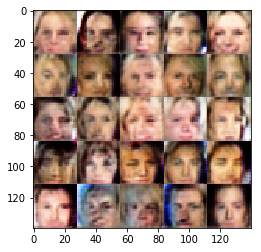

Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.3326
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.3309
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.9439


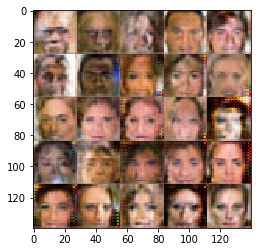

Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.9139


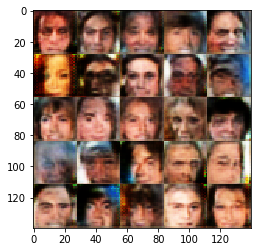

Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.4326
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 2.2532
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 1.0129


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.